# Time series clustering

In [20]:
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gpd
import psycopg2
from psycopg2 import sql
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import os
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape
from tslearn.utils import to_time_series_dataset

# move current directory to /Users/tanyatsui/Documents/01_Projects/housingEmissions
os.chdir('/Users/tanyatsui/Documents/01_Projects/housingEmissions')

In [2]:
# create a connection to the database
db_name = 'urbanmining'
db_user = 'postgres'
db_password = 'Tunacompany5694!'
db_host = 'localhost'
db_port = '5432'
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')


In [90]:
query = ''' 
SELECT bu_code, year, 
	embodied_kg + operational_kg AS total_kg 
FROM emissions_all_buurt
WHERE embodied_kg IS NOT NULL AND operational_kg IS NOT NULL
'''

df = pd.read_sql_query(query, engine)
df = df.pivot(index='bu_code', columns='year', values='total_kg')
df = df[~df.isnull().any(axis=1)]
df = df.dropna()
df = df.apply(lambda x: x.rolling(window=3, min_periods=1).mean(), axis=1)

# K-shape clustering

In [91]:
data = df.to_numpy()
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1)  # Mean 0, Variance 1
data_normalized = scaler.fit_transform(data)
time_series_data = to_time_series_dataset(data_normalized)

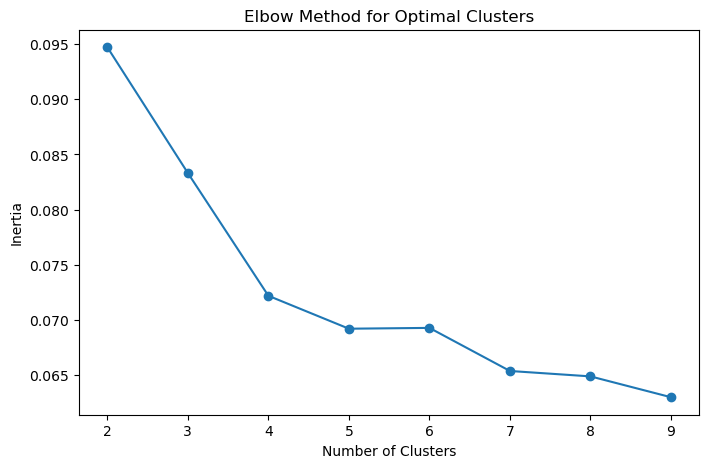

In [45]:
data_3d = time_series_data.copy() 

inertia = []
cluster_range = range(2, 10)  # Test clusters from 2 to 10
for n_clusters in cluster_range:
    kshape = KShape(n_clusters=n_clusters, random_state=42)
    kshape.fit(data_3d)
    inertia.append(kshape.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

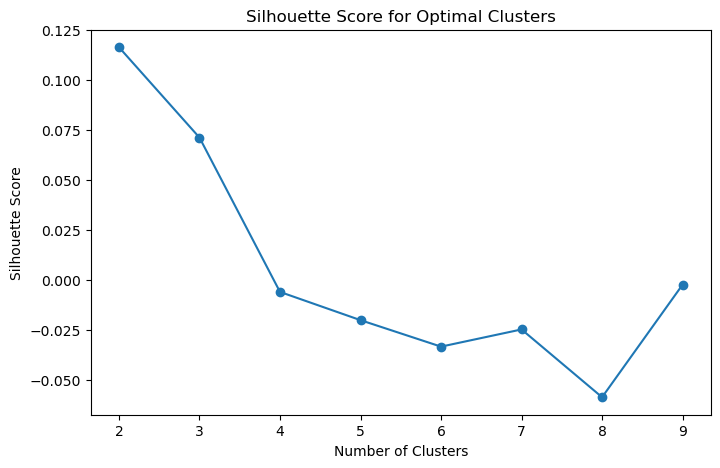

In [46]:
from sklearn.metrics import silhouette_score

# Flatten the 3D data (remove the last dimension)
data_flattened = data_3d[:, :, 0]  # Shape becomes (n_samples, n_timestamps)

# Calculate Silhouette scores for different cluster counts
silhouette_scores = []
for n_clusters in cluster_range:
    kshape = KShape(n_clusters=n_clusters, random_state=42)
    labels = kshape.fit_predict(data_3d)
    # Compute silhouette score using the flattened dataset
    score = silhouette_score(data_flattened, labels, metric="euclidean")
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

In [97]:
n_clusters = 3  # Number of clusters (adjust as needed)
kshape = KShape(n_clusters=n_clusters, verbose=True, random_state=42)
labels = kshape.fit_predict(time_series_data)

0.059 --> 0.077 --> 


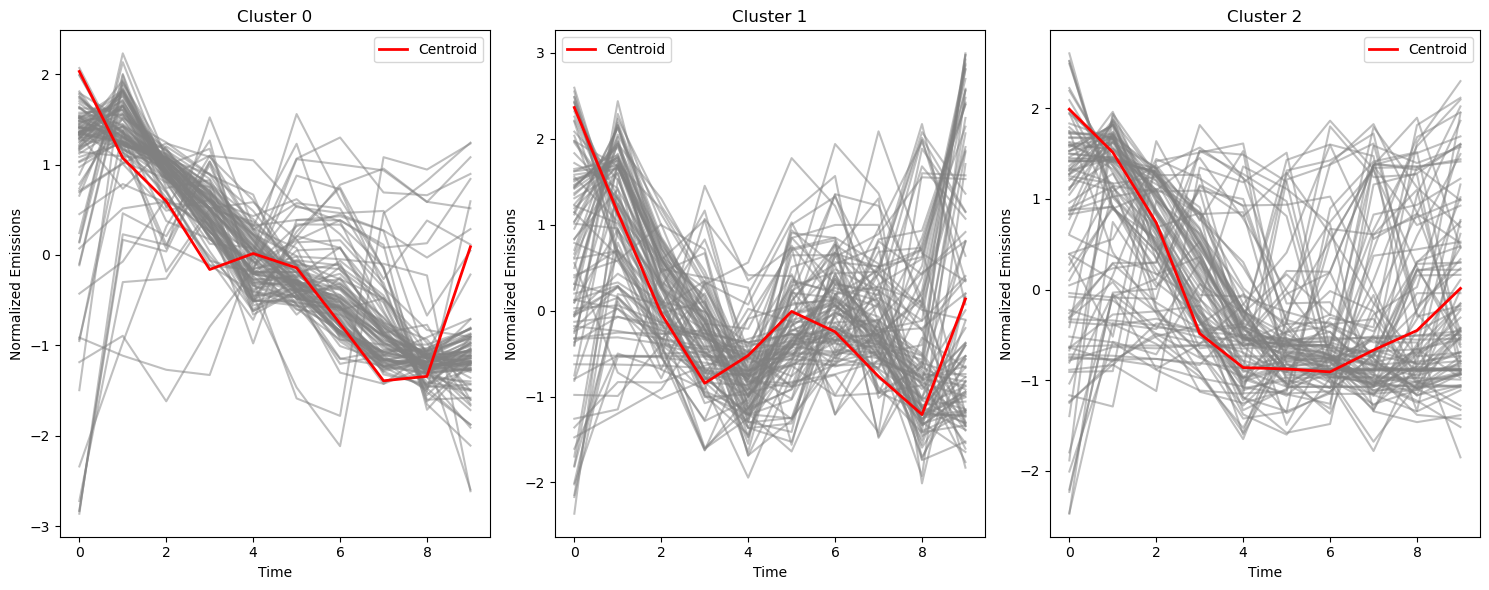

Cluster Labels: [0 0 2 ... 2 2 2]


In [98]:
# Step 4: Visualize Clusters
# Plot each cluster with its centroid
plt.figure(figsize=(15, 6))
for cluster_idx in range(n_clusters):
    plt.subplot(1, n_clusters, cluster_idx + 1)
    
    # Get time series in the current cluster
    cluster_members = time_series_data[labels == cluster_idx]
    
    # Plot all time series in the cluster
    for series in cluster_members[:100]:
        plt.plot(series.flatten(), "gray", alpha=0.5)
    
    # Plot cluster centroid
    centroid = kshape.cluster_centers_[cluster_idx].flatten()
    plt.plot(centroid, "red", linewidth=2, label="Centroid")
    plt.title(f"Cluster {cluster_idx}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Emissions")
    plt.legend()

plt.tight_layout()
plt.show()

# Step 5: Display Cluster Labels
print("Cluster Labels:", labels)

# Dynamic time warping based clustering

In [104]:
class DTWBasedClustering: 

    def __init__(self, df_raw, column_name, n_clusters): 
        self.df_raw = df_raw
        self.column_name = column_name
        self.n_clusters = n_clusters

    def pre_process_data(self):
        df = self.df_raw.pivot(index='bu_code', columns='year', values=self.column_name)
        df = df[~df.isnull().any(axis=1)]
        df = df.dropna()
        data_array = df.to_numpy()

        from tslearn.clustering import TimeSeriesKMeans
        scaler = TimeSeriesScalerMeanVariance(mu=0, std=1)  # Mean 0, Std Dev 1
        data_normalized = scaler.fit_transform(data_array)  # Shape: (n_samples, n_timestamps, 1)
        data_3d = to_time_series_dataset(data_normalized)

        self.df = df
        self.data_3d = data_3d

    def elbow_and_silhouette_score(self): 
        from tslearn.clustering import TimeSeriesKMeans
        from tslearn.metrics import cdist_dtw
        from sklearn.metrics import silhouette_score
        import matplotlib.pyplot as plt

        # Flatten the 3D time-series data for DTW distance calculation
        data_flattened = self.data_3d[:, :, 0]  # Shape becomes (n_samples, n_timestamps)

        # Define the range of clusters to test
        cluster_range = range(2, 3)  # Test clusters from 2 to 10
        inertia = []  # For the Elbow Method
        silhouette_scores_dtw = []  # For the DTW-specific Silhouette Method

        # Precompute pairwise DTW distances
        dtw_distances = cdist_dtw(data_flattened)

        # Loop through each number of clusters and compute metrics
        for n_clusters in cluster_range:
            model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
            labels = model.fit_predict(data_3d)
            
            # Store inertia for Elbow Method
            inertia.append(model.inertia_)
            
            # Calculate silhouette score using DTW distances
            score = silhouette_score(dtw_distances, labels, metric="precomputed")
            silhouette_scores_dtw.append(score)

        # Plot the Elbow Method (Inertia)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(cluster_range, inertia, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia')
        plt.title('Elbow Method')

        # Plot the Silhouette Score (DTW)
        plt.subplot(1, 2, 2)
        plt.plot(cluster_range, silhouette_scores_dtw, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Silhouette Score (DTW)')
        plt.title('Silhouette Score Method (DTW)')

        plt.tight_layout()
        plt.show()

        return None 

    def assign_clusters(self): 
        from tslearn.clustering import TimeSeriesKMeans
        self.model = TimeSeriesKMeans(n_clusters=self.n_clusters, metric="dtw", random_state=42)
        self.labels = self.model.fit_predict(self.data_3d)
        self.df['Cluster'] = self.labels

    def plot_clusters(self): 
        import matplotlib.pyplot as plt
        import math

        max_charts_per_row = 3
        n_rows = math.ceil(self.n_clusters / max_charts_per_row)

        plt.figure(figsize=(15, 5 * n_rows))
        for cluster_idx in range(self.n_clusters):
            # subplot_index = cluster_idx + 1  # Subplot index starts from 1
            # if subplot_index > n_rows * max_charts_per_row:
            #     break  # Ensure we do not exceed the grid

            plt.subplot(n_rows, max_charts_per_row, cluster_idx+1)
            cluster_members = self.data_3d[self.labels == cluster_idx]
            for series in cluster_members[:100]:
                plt.plot(series.flatten(), color="gray", alpha=0.5)
            plt.plot(self.model.cluster_centers_[cluster_idx].flatten(), color="red", label="Centroid")
            plt.title(f"Cluster {cluster_idx}")
            plt.xlabel("Time")
            plt.ylabel("Normalized Emissions")
            plt.legend()

        plt.tight_layout()
        plt.show()

In [102]:
query = ''' 
SELECT bu_code, year, 
	embodied_kg, operational_kg,
	embodied_kg + operational_kg AS total_kg, 
    embodied_kg / n_homes AS embodied_kg_per_home,
    operational_kg / n_homes AS operational_kg_per_home, 
    (embodied_kg + operational_kg) / n_homes AS total_kg_per_home
FROM emissions_all_buurt
WHERE 
	embodied_kg IS NOT NULL AND operational_kg IS NOT NULL 
	AND n_homes > 0
'''

df_raw = pd.read_sql_query(query, engine)

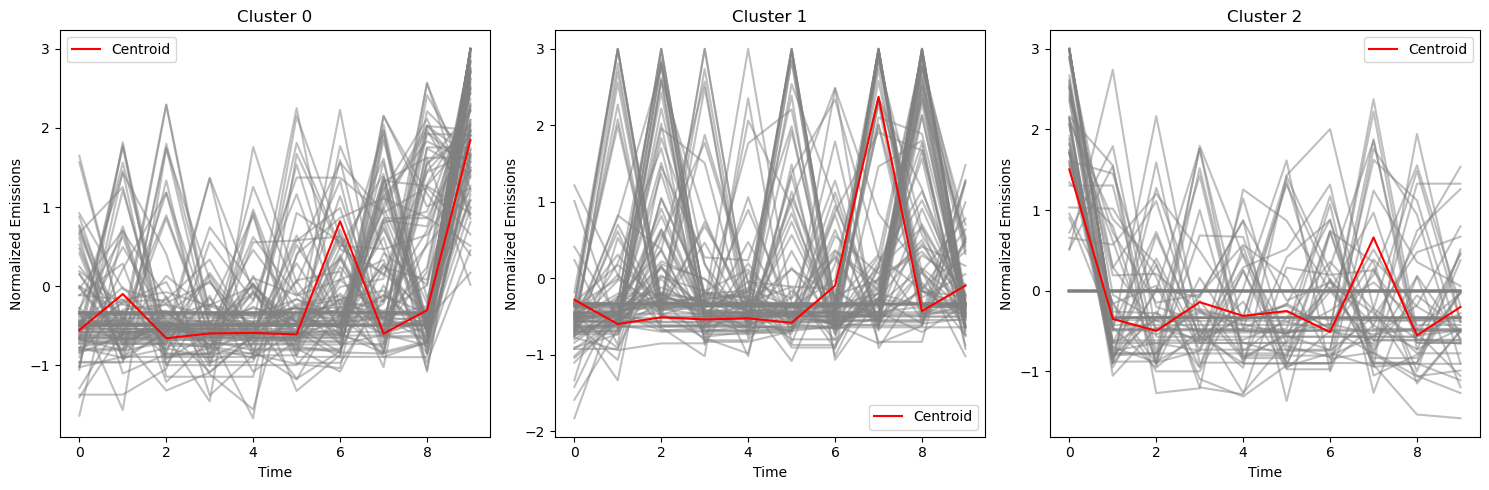

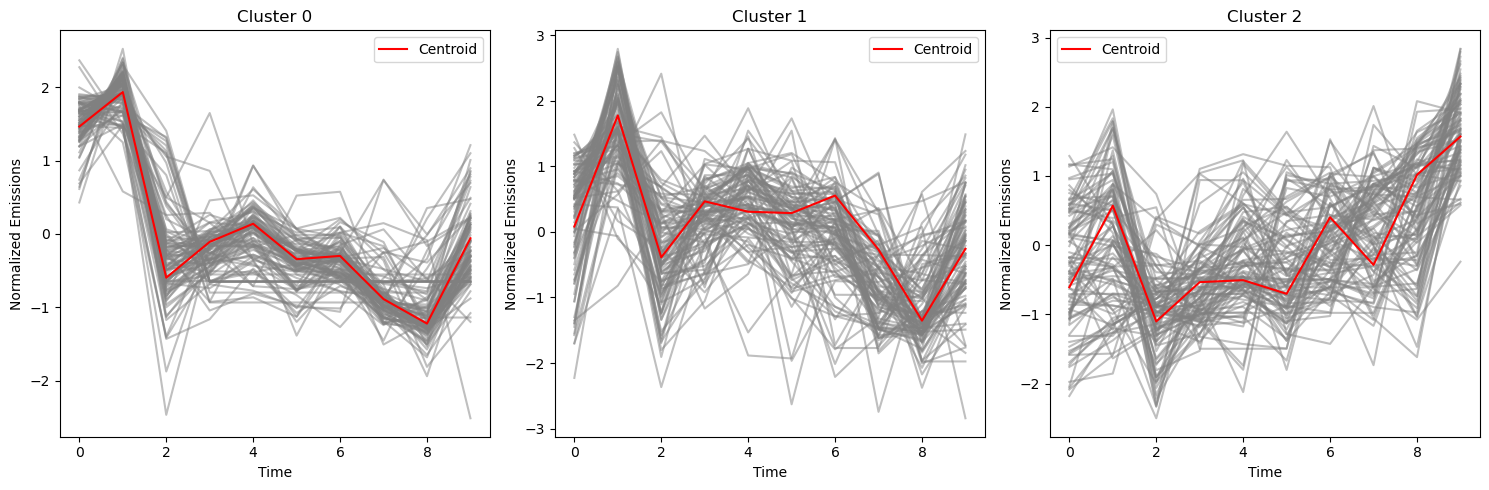

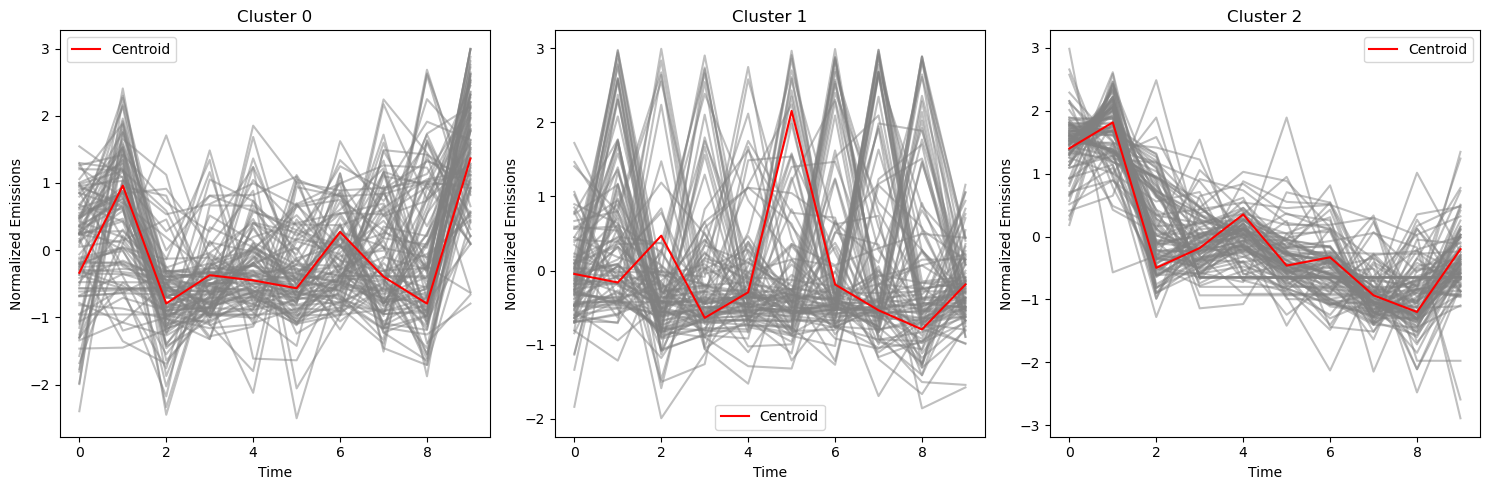

In [87]:
for col_name in ['embodied_kg', 'operational_kg', 'total_kg']:
    dtw_model = DTWBasedClustering(df_raw, col_name, 3)
    dtw_model.pre_process_data()
    dtw_model.assign_clusters()
    dtw_model.plot_clusters()

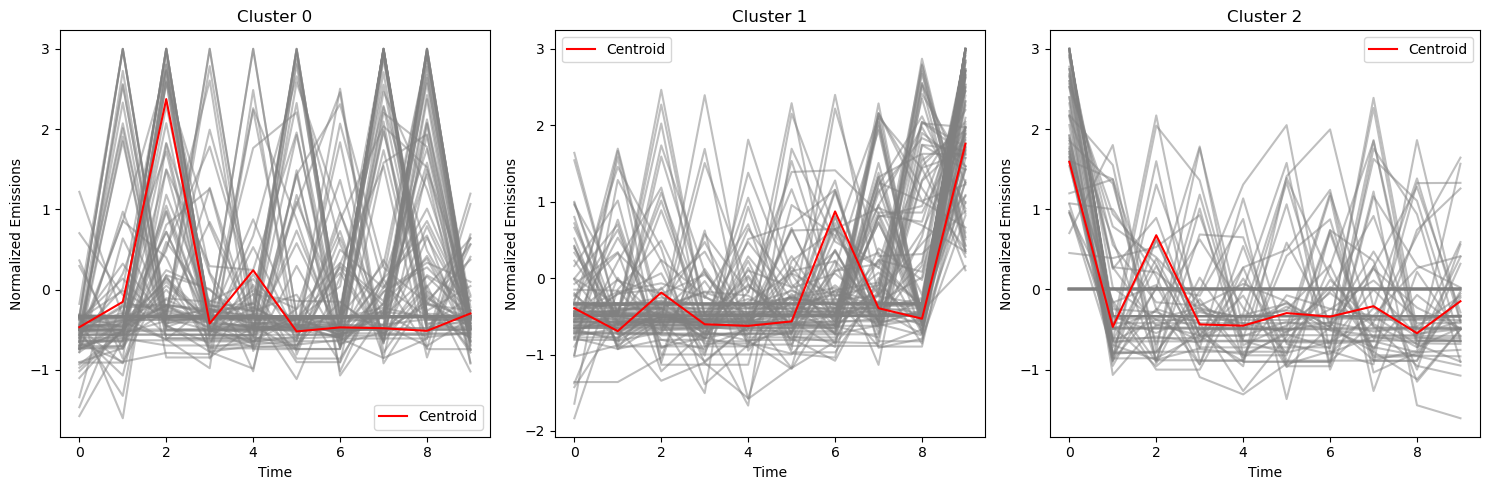

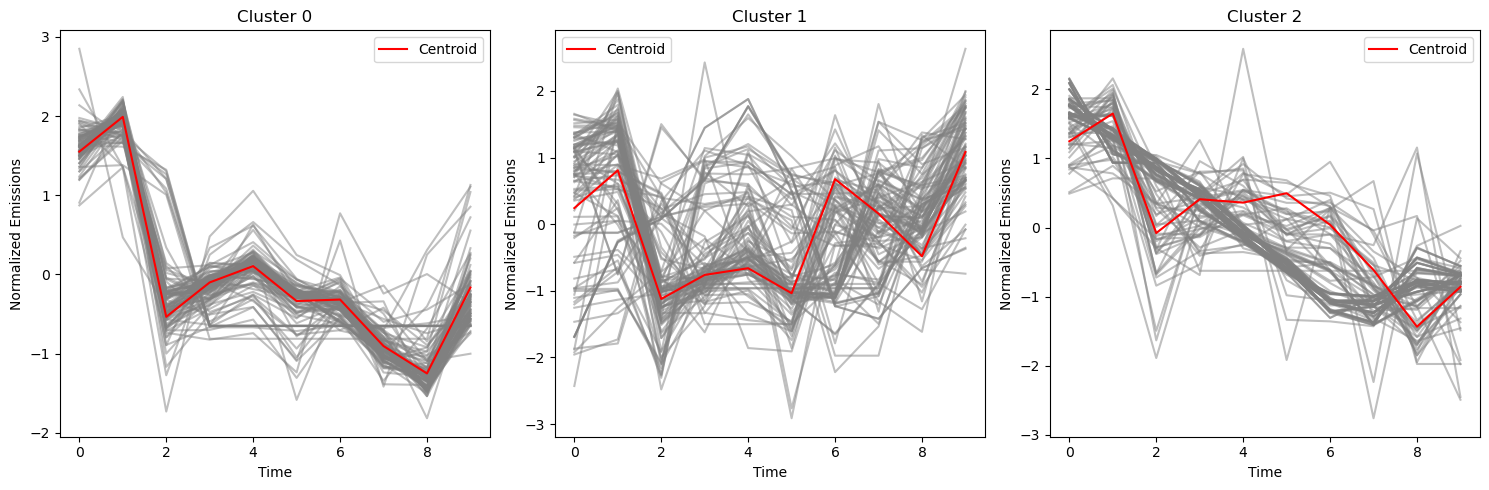

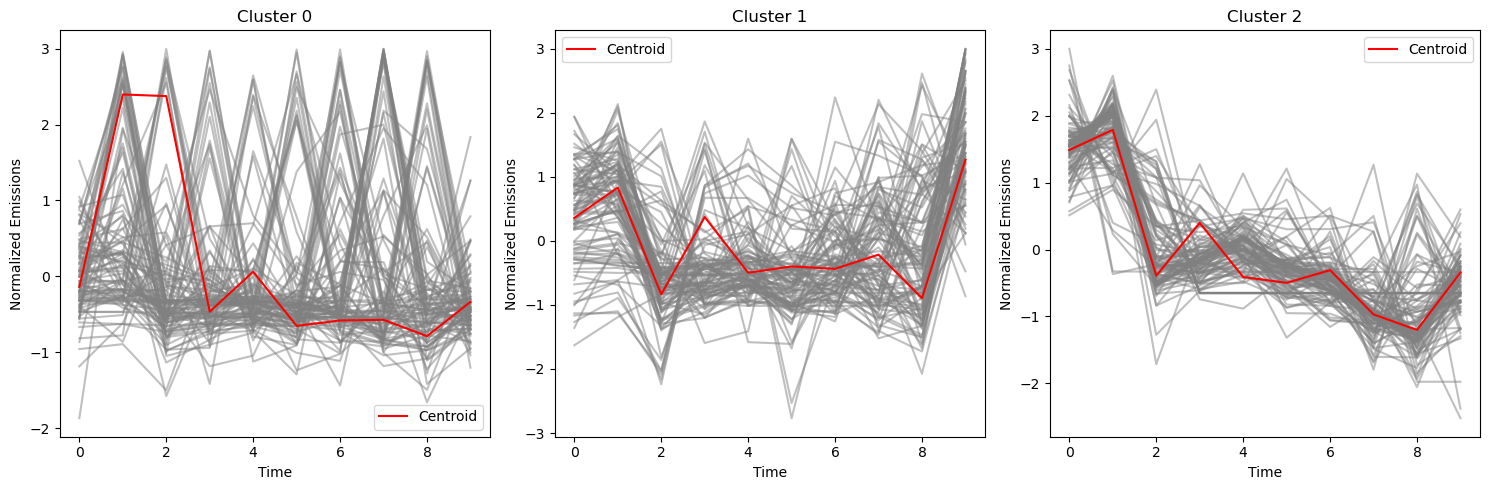

In [105]:
for col_name in ['embodied_kg_per_home', 'operational_kg_per_home', 'total_kg_per_home']:
    dtw_model = DTWBasedClustering(df_raw, col_name, 3)
    dtw_model.pre_process_data()
    dtw_model.assign_clusters()
    dtw_model.plot_clusters()

In [100]:
dtw_model = DTWBasedClustering(df_raw, 'total_kg', 3)
dtw_model.pre_process_data()
dtw_model.elbow_and_silhouette_score()

KeyboardInterrupt: 

# Euclidean distsance clustering